# XGB test


In [218]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [219]:
import pandas as pd

import seaborn as sns

from math import log

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from xgboost import XGBRegressor
# import shap


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from plots2.fns import (
    get_corner_annotations,
    get_corner_annotations_custom_labels,
)

from poly2.utils import trait_vec, gamma_dist, object_dump, object_load
from poly2.config import Config

In [220]:
from poly2.utils import load_train_test_data, HyperparamsObj
import optuna
from optuna.samplers import TPESampler

# combine hyperparam dfs

In [249]:
def combine_hyperparam_dfs(model):
    df = (
        pd.read_csv(f'../outputs/hyperparams/{model}.csv')
        .sort_values('best_cv_score')
    )
    
    if True:
        fn = f'../outputs/hyperparams/best/{model}.csv'
        print(f'saving to {fn}')
        df.head(1).to_csv(fn, index=False)
    return df

In [296]:
MODEL = 'cumulative'

In [297]:
df = combine_hyperparam_dfs(MODEL)

saving to ../outputs/hyperparams/best/cumulative.csv


In [298]:
df.head()

,max_depth,n_estimators,learning_rate,subsample,colsample_bytree,tree_method,model,default_cv_score,best_cv_score,rmse_test,rmse_train,rmse_test_def,number
104,8,824,0.038247,0.815209,0.973270,hist,cumulative,0.061718,0.049272,0.043690,0.016437,0.05694,30
110,8,1127,0.016080,0.745699,0.943711,hist,cumulative,0.061718,0.049417,0.044358,0.019745,0.05694,11
55,8,874,0.037557,0.807692,0.884989,hist,cumulative,0.061718,0.049428,0.043610,0.016215,0.05694,9
168,8,1290,0.061905,0.824162,0.940336,hist,cumulative,0.061718,0.049508,0.044191,0.011116,0.05694,38
99,8,1557,0.011411,0.708540,0.922726,hist,cumulative,0.061718,0.049591,0.044374,0.019822,0.05694,43


Visualise the dataset of the best result from each of the 200 runs of 50

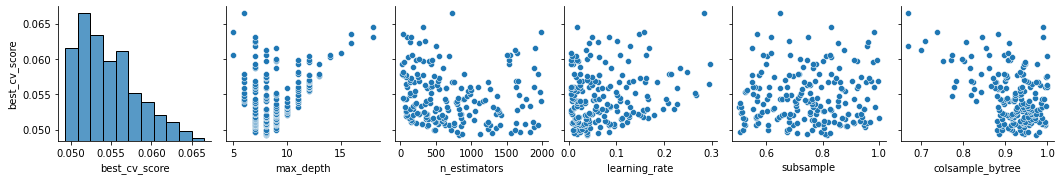

In [299]:
sns.pairplot(
    df.loc[:, [
        'best_cv_score', 
        'max_depth',
        'n_estimators',
        'learning_rate',
        'subsample',
        'colsample_bytree',
    ]],
    # corner=True,
    y_vars=['best_cv_score'],
    # hue='best_cv_score',
    # palette='rocket',
)

# Can we replicate?

Might have to be satisfied if agree to XX s.f. because of floating point errors / inexact saving

In [300]:
best_pars = (
    df
    .head(1)
    .loc[:, [
        'max_depth',
        'n_estimators',
        'learning_rate',
        'subsample',
        'colsample_bytree',
        'tree_method',
    ]]
    .iloc[0]
    .to_dict()
)

In [301]:
X_train, y_train, X_test, y_test = load_train_test_data(MODEL)

In [302]:
best_model = XGBRegressor(**best_pars).fit(X_train, y_train)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [303]:
yp_train = best_model.predict(X_train)
yp_test = best_model.predict(X_test)

In [304]:
rmse_train = mean_squared_error(yp_train, y_train, squared=False)
rmse_test = mean_squared_error(yp_test, y_test, squared=False)

In [305]:
rmse_test.round(6), rmse_train.round(6)

(0.044345, 0.016473)

In [306]:
df.filter(like='rmse_').head(1).drop(['rmse_test_def'], axis=1)

,rmse_test,rmse_train
104,0.04369,0.016437
